In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Card:
    def __init__(self, suit, num):
        self.suit = suit
        self.number = num
    
    def display(self):
        return f"{self.number}{self.suit}"

In [3]:
class Deck:
    def __init__(self):
        self.card_ls = []
        suits = "♠️ ♣️ ♥️ ♦️".split(" ")
        nums = "2 3 4 5 6 7 8 9 10 J Q K A".split(" ")
        for _ in range(4): # Using a 4-deck shoe for a better simulation
            for i in suits:
                for j in nums:
                    self.card_ls.append(Card(suit=i, num=j))
        random.shuffle(self.card_ls)

    def draw_card(self):
        if not self.card_ls:
            self.__init__() # Reshuffle if deck runs out
        return self.card_ls.pop(0)

In [4]:
class Player:
    def __init__(self, name):
        self.name = name
        self.hand = []
    
    def draw_card(self, card: Card):
        self.hand.append(card)

    def sum_score(self) -> int:
        number2score = {"A":11, "2":2, "3":3, "4":4, "5":5, "6":6, "7":7, "8":8, "9":9, "10":10, "J":10, "Q":10, "K":10}
        score = 0
        num_aces = 0
        for c in self.hand:
            if c.number == "A":
                num_aces += 1
            score += number2score[c.number]
        
        while score > 21 and num_aces > 0:
            score -= 10
            num_aces -= 1
        return score
    
    def is_busted(self):
        return self.sum_score() > 21

    def is_blackjack(self):
        return self.sum_score() == 21

In [5]:
class Dealer:
    def __init__(self):
        self.hand = []

    def draw_card(self, card: Card):
        self.hand.append(card)

    def sum_score(self) -> int:
        number2score = {"A":11, "2":2, "3":3, "4":4, "5":5, "6":6, "7":7, "8":8, "9":9, "10":10, "J":10, "Q":10, "K":10}
        score = 0
        num_aces = 0
        for c in self.hand:
            if c.number == "A":
                num_aces += 1
            score += number2score[c.number]
        
        while score > 21 and num_aces > 0:
            score -= 10
            num_aces -= 1
        return score
    
    def is_busted(self):
        return self.sum_score() > 21
    
    def is_blackjack(self):
        return self.sum_score() == 21

    def make_decision(self) -> bool:
        return self.sum_score() < 17

In [7]:
def simulate_one_game(player_hand_str, dealer_up_card_str, first_action):
    deck = Deck()
    player = Player("Jen")
    dealer = Dealer()

    player.hand = [Card("♠️", s) for s in player_hand_str]
    dealer.hand = [Card("♦️", dealer_up_card_str), deck.draw_card()]

    is_first_move = True
    while True:
        if player.is_busted():
            break
        
        action = 'S'
        if is_first_move:
            action = first_action
            is_first_move = False
        else:
            if player.sum_score() < 17:
                action = 'H'
        
        if action == 'S':
            break
        player.draw_card(deck.draw_card())

    if player.is_busted():
        return False
    
    while dealer.make_decision():
        dealer.draw_card(deck.draw_card())
    
    player_score = player.sum_score()
    dealer_score = dealer.sum_score()

    if dealer.is_busted() or (player_score > dealer_score):
        return True
    else:
        return False

In [8]:
def run_simulation():
    player_totals = list(range(4, 21))
    
    hit_winrates = []
    stand_winrates = []

    for player_total in player_totals:
        hit_row = []
        stand_row = []
        
        if player_total >= 13: 
            hand_str = ['A', str(player_total - 11)]
        else: 
            if player_total == 12:
                hand_str = ['10', '2']
            else: 
                hand_str = [str(player_total//2), str(player_total - (player_total//2))]

        for dealer_card in "2 3 4 5 6 7 8 9 10 A".split(" "):
            num_games = 10000
            hit_wins = sum(simulate_one_game(hand_str, dealer_card, 'H') for _ in range(num_games))
            stand_wins = sum(simulate_one_game(hand_str, dealer_card, 'S') for _ in range(num_games))

            hit_row.append(hit_wins / num_games)
            stand_row.append(stand_wins / num_games)
        
        hit_winrates.append(hit_row)
        stand_winrates.append(stand_row)
        
    return hit_winrates, stand_winrates

In [9]:
def plot_strategy_table(hit_rates, stand_rates, player_totals, dealer_cards):
    fig, ax = plt.subplots(figsize=(12, 8))
    hit_rates = np.array(hit_rates)
    stand_rates = np.array(stand_rates)
    decisions = hit_rates >= stand_rates
    
    for i in range(len(player_totals)):
        for j in range(len(dealer_cards)):
            is_hit = decisions[i, j]
            color = '#90EE90' if is_hit else '#F08080'
            label = 'H' if is_hit else 'S'
            ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color=color, ec='black'))
            ax.text(j, i, label, ha='center', va='center', fontsize=16, fontweight='bold', color='black')

    ax.set_xticks(np.arange(len(dealer_cards)))
    ax.set_xticklabels(dealer_cards, fontsize=12)
    ax.set_yticks(np.arange(len(player_totals)))
    ax.set_yticklabels(player_totals, fontsize=12)
    ax.xaxis.set_ticks_position('top'); ax.xaxis.set_label_position('top')
    ax.set_xlabel("Dealer's Up Card", fontsize=14, labelpad=10)
    ax.set_ylabel("Player's Hand Total", fontsize=14, labelpad=10)
    ax.set_xlim(-0.5, len(dealer_cards)-0.5); ax.set_ylim(-0.5, len(player_totals)-0.5)
    ax.invert_yaxis()
    ax.set_title("Optimal Strategy (H=Hit, S=Stand)", fontsize=16, pad=40)
    plt.tight_layout()
    plt.show()

In [15]:
def plot_winrate_table(winrates, title, cmap, player_totals, dealer_cards):
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.imshow(np.array(winrates), cmap=cmap, aspect='auto', vmin=0, vmax=0.7)
    
    for i in range(len(player_totals)):
        for j in range(len(dealer_cards)):
            ax.text(j, i, f"{np.array(winrates)[i, j]*100:.0f}%", ha='center', va='center', fontsize=10, color='black')

    ax.set_xticks(np.arange(len(dealer_cards)))
    ax.set_xticklabels(dealer_cards, fontsize=12)
    ax.set_yticks(np.arange(len(player_totals)))
    ax.set_yticklabels(player_totals, fontsize=12)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xlabel("Dealer's Up Card", fontsize=14, labelpad=10)
    ax.set_ylabel("Player's Hand Total", fontsize=14, labelpad=10)
    # ax.invert_yaxis()  # <--- remove this line
    ax.set_title(title, fontsize=16, pad=40)
    plt.tight_layout()
    plt.show()


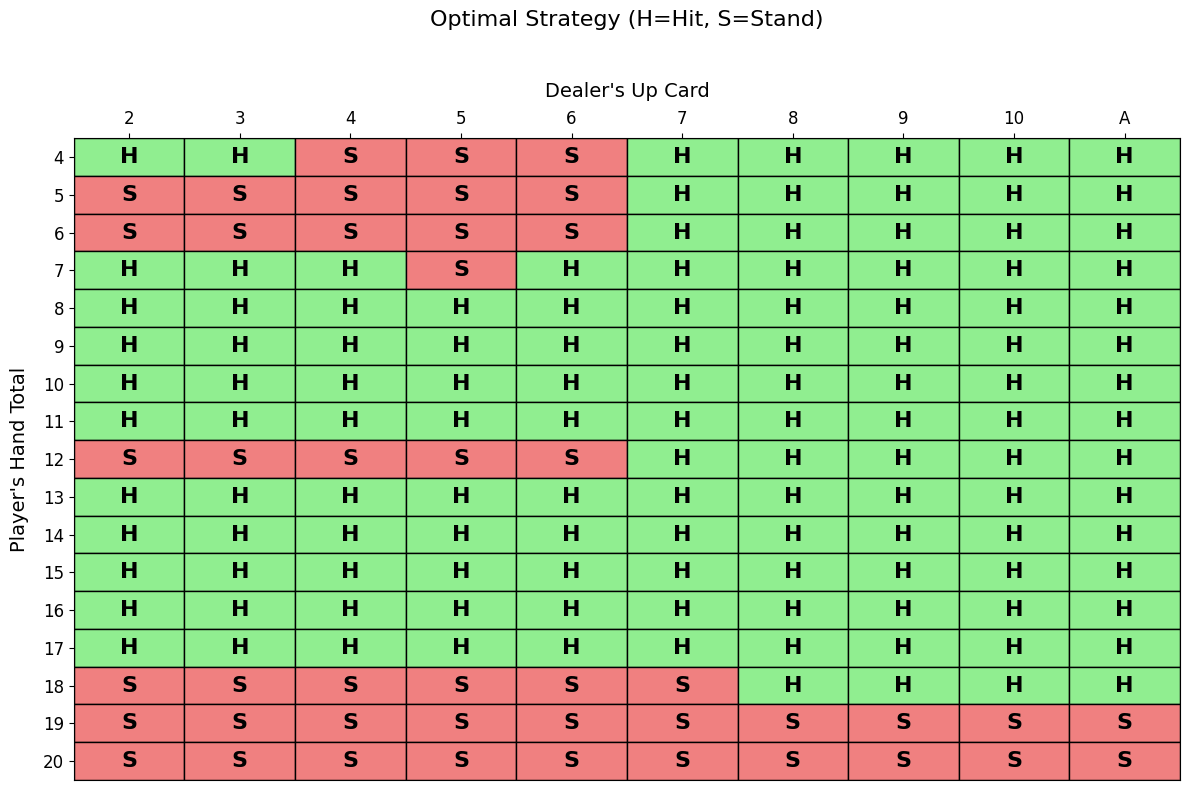

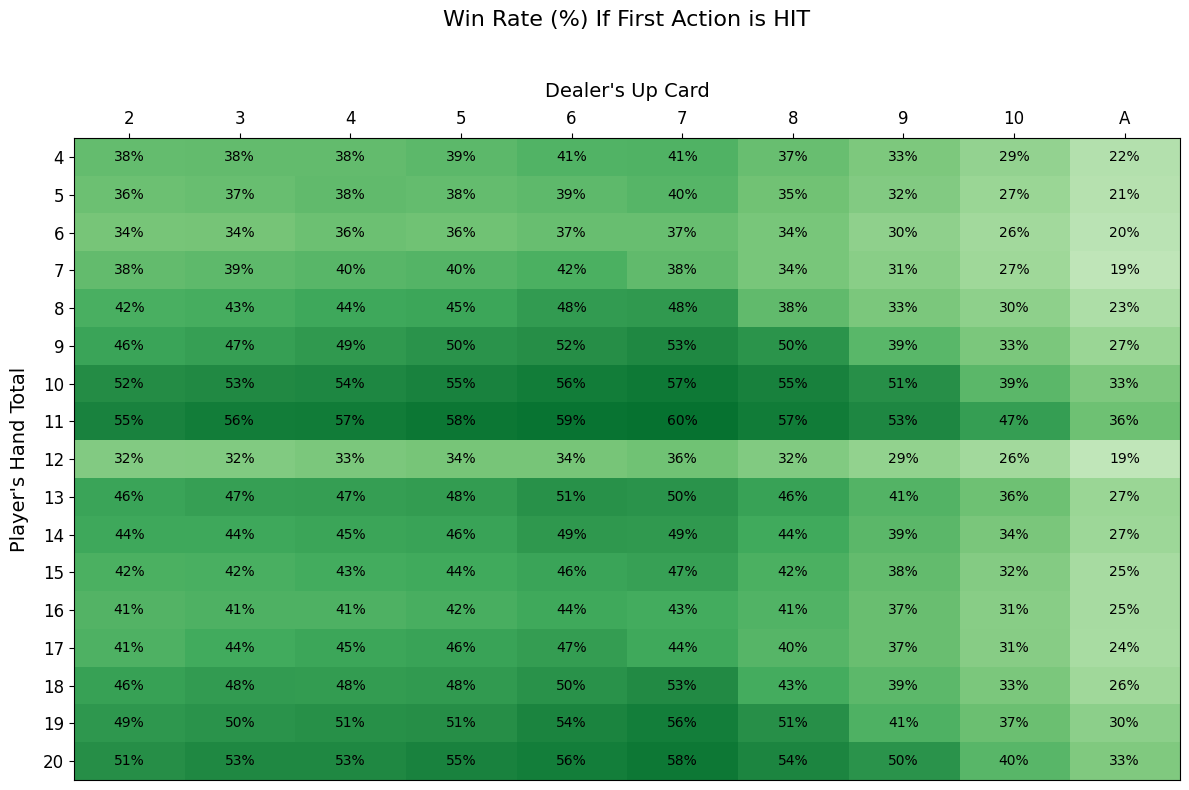

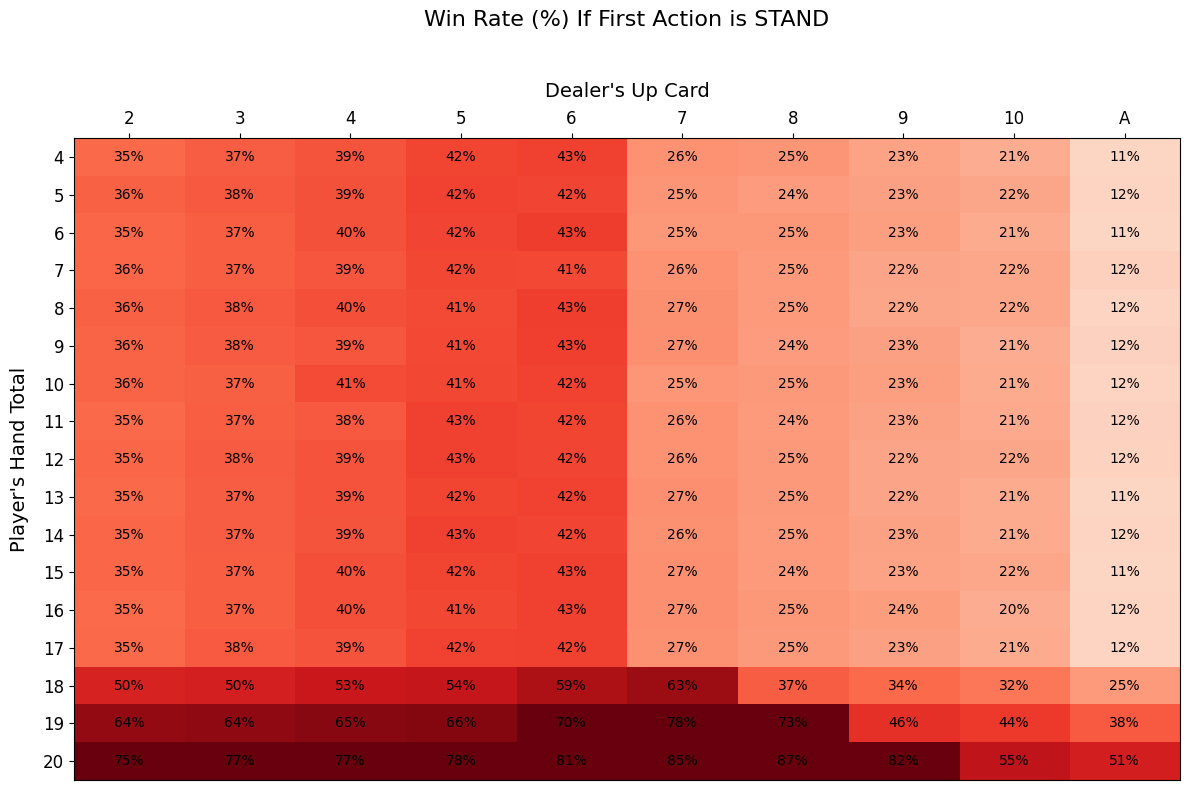

In [16]:
if __name__ == "__main__":
    hit_rates, stand_rates = run_simulation()
    
    player_totals_labels = list(range(4, 21))
    dealer_cards_labels = "2 3 4 5 6 7 8 9 10 A".split(" ")

    plot_strategy_table(hit_rates, stand_rates, player_totals_labels, dealer_cards_labels)
    plot_winrate_table(hit_rates, "Win Rate (%) If First Action is HIT", 'Greens', player_totals_labels, dealer_cards_labels)
    plot_winrate_table(stand_rates, "Win Rate (%) If First Action is STAND", 'Reds', player_totals_labels, dealer_cards_labels)